<a href="https://colab.research.google.com/github/tolerant-code/Deep-Learning-Project/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Deep Learning Group Project**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
import os#import the Os module for file management tasks handling
import shutil# this module is used provides a high-level interface for file operations
# Move existing files
existing_files = os.listdir('/content/drive')
for file in existing_files:
  shutil.move(os.path.join('/content/drive', file), '/content/gdrive')
# Now mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step1 Importing Necessary Packages**

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt # this module is imported for creating visualization like barchart
from sklearn.model_selection import train_test_split# for spliting the data set in to trainning and testing set
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # to stop the training of a neural network when a monitored metric has stopped improving

# **Load Dataset Folder and Array of Genres**

In [ ]:
GTZAN = "/content/drive/MyDrive/Colab Notebooks/GTZAN"# the dataset folder

In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']# the genres of the music

# **View Sample Spectrogram Image for Each Genre**

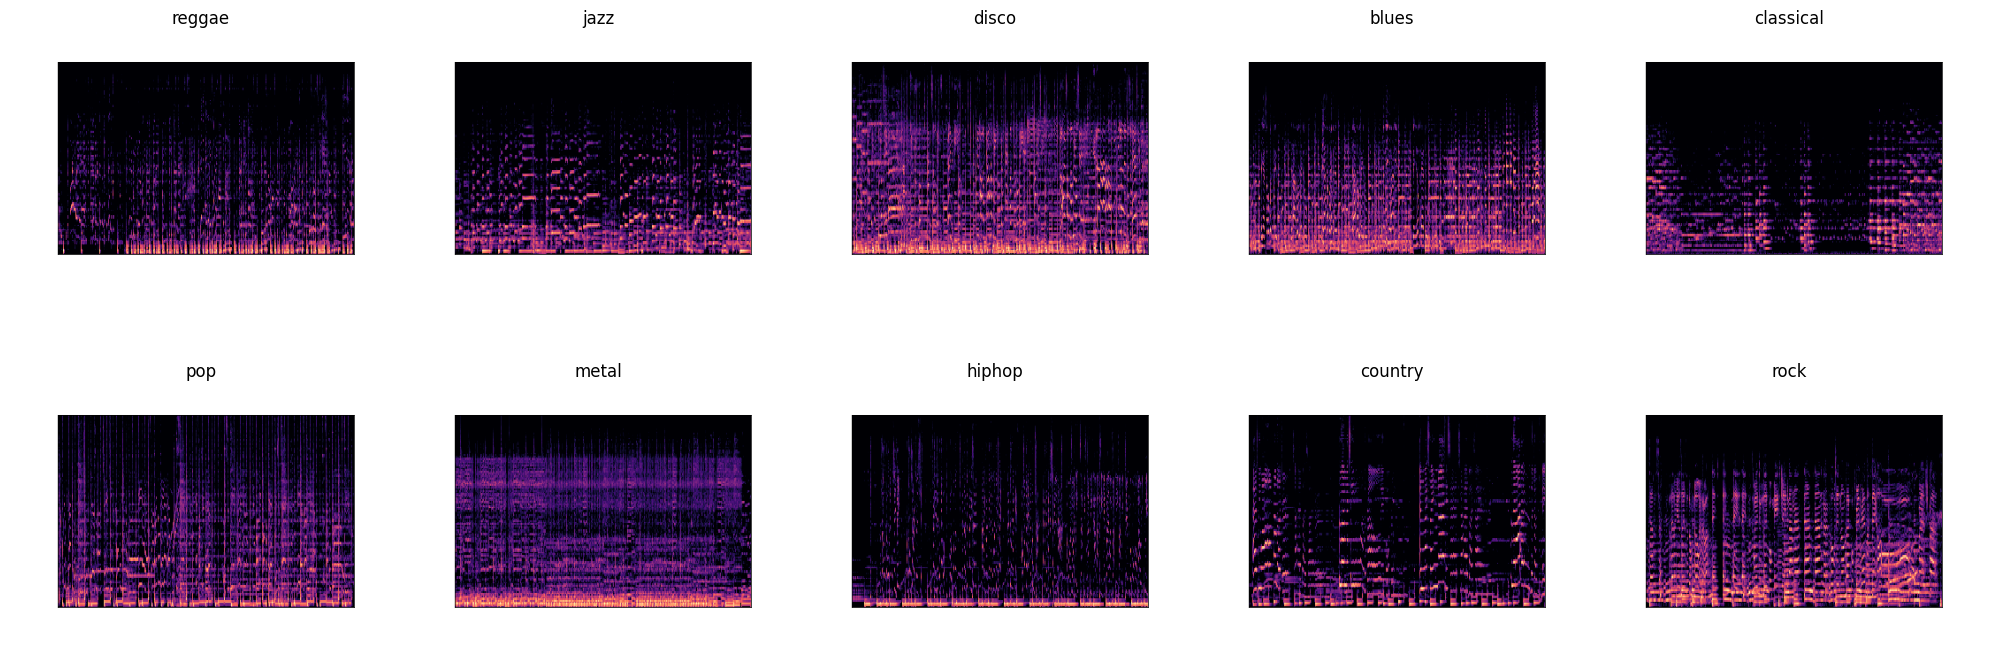

In [ ]:
import os
from PIL import Image

# List all the genres in the GTZAN directory and convert them to lowercase
genres = os.listdir(GTZAN)
genres = [genre.lower() for genre in genres]

# Create a plot with 2 rows and 5 columns, and set the figure size
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Iterate through each genre
for i in range(len(genres)):
    # Determine the row and column index of the subplot
    row = i // 5
    col = i % 5
    # Get the path to the genre directory and the path to the first image in the genre directory
    genre_path = os.path.join(GTZAN, genres[i].lower())
    image_path = os.path.join(genre_path, os.listdir(genre_path)[0])
    # Open the image and display it in the subplot
    image = Image.open(image_path)
    axs[row][col].imshow(image)
    # Set the title of the subplot to the genre name and turn off the axis labels
    axs[row][col].set_title(genres[i])
    axs[row][col].axis('off')

    # Save the image with 300dpi in the same directory with the genre name as the file name
    save_path = os.path.join(genre_path, f"{genres[i]}.png")
    image.save(save_path, dpi=(300, 300))

# Adjust the spacing between the subplots and display the plot
plt.tight_layout()
plt.show()

after ssuccessfully loading the dataset we are going to build a CNN model and train it for testing and deployment

## **Build CNN Model**

In [ ]:
import os
import shutil
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the combined dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/GTZAN'

# Define the path to save the split dataset
base_dir = '/content/drive/MyDrive/Colab Notebooks/GTZAN2'

img_size = (128, 128)
batch_size = 32

# Define the subdirectories for training, validation, and testing sets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create the subdirectories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the data into training, validation, and testing sets
for genre in os.listdir(data_dir):
    genre_dir = os.path.join(data_dir, genre)
    file_list = os.listdir(genre_dir)
    random.shuffle(file_list)
    num_files = len(file_list)
    train_files = file_list[:int(num_files*0.7)]
    val_files = file_list[int(num_files*0.7):int(num_files*0.8)]
    test_files = file_list[int(num_files*0.8):]

    train_genre_dir = os.path.join(train_dir, genre)
    val_genre_dir = os.path.join(val_dir, genre)
    test_genre_dir = os.path.join(test_dir, genre)

    os.makedirs(train_genre_dir, exist_ok=True)
    os.makedirs(val_genre_dir, exist_ok=True)
    os.makedirs(test_genre_dir, exist_ok=True)

    for train_file in train_files:
        src = os.path.join(genre_dir, train_file)
        dst = os.path.join(train_genre_dir, train_file)
        shutil.copyfile(src, dst)

    for val_file in val_files:
        src = os.path.join(genre_dir, val_file)
        dst = os.path.join(val_genre_dir, val_file)
        shutil.copyfile(src, dst)

    for test_file in test_files:
        src = os.path.join(genre_dir, test_file)
        dst = os.path.join(test_genre_dir, test_file)
        shutil.copyfile(src, dst)

# Create an ImageDataGenerator object for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the train, validation, and test generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=img_size,
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=5)

# Train the model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stop])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print('\nTest accuracy:', test_acc)

Found 973 images belonging to 10 classes.
Found 271 images belonging to 10 classes.
Found 501 images belonging to 10 classes.
Epoch 1/100
31/31 [==============================] - 87s 3s/step - loss: 2.2748 - accuracy: 0.1357 - val_loss: 2.2772 - val_accuracy: 0.1771
Epoch 2/100
31/31 [==============================] - 56s 2s/step - loss: 2.1085 - accuracy: 0.2282 - val_loss: 2.0358 - val_accuracy: 0.2251
Epoch 3/100
31/31 [==============================] - 56s 2s/step - loss: 2.0363 - accuracy: 0.2425 - val_loss: 2.1506 - val_accuracy: 0.2103
Epoch 4/100
31/31 [==============================] - 59s 2s/step - loss: 1.9070 - accuracy: 0.3104 - val_loss: 1.7759 - val_accuracy: 0.3247
Epoch 5/100
31/31 [==============================] - 53s 2s/step - loss: 1.7760 - accuracy: 0.3844 - val_loss: 1.6004 - val_accuracy: 0.3985
Epoch 6/100
31/31 [==============================] - 53s 2s/step - loss: 1.6650 - accuracy: 0.4142 - val_loss: 1.5877 - val_accuracy: 0.4465
Epoch 7/100
31/31 [=========

# **Evaluate Using Learning Curve**

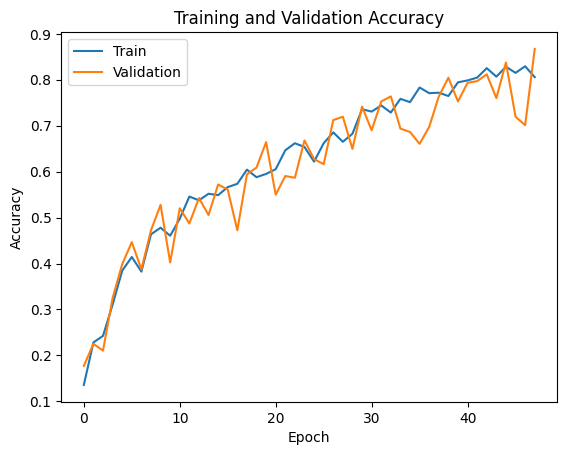

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("train_and_val_acc.png", bbox_inches="tight", dpi=300)
plt.show()

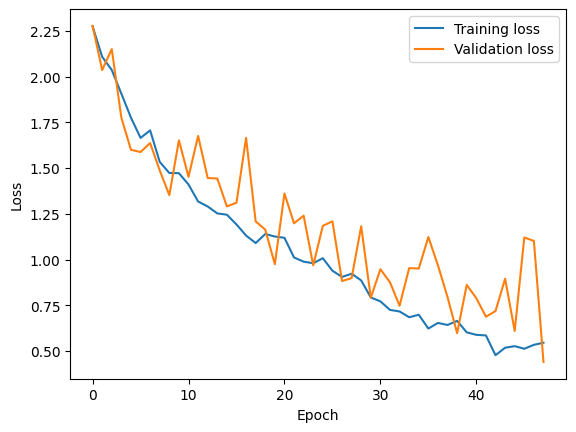

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_and_val_loss.png", bbox_inches="tight", dpi=300)
plt.show()

# **Confusion Matrix**

16/16 [==============================] - 9s 543ms/step


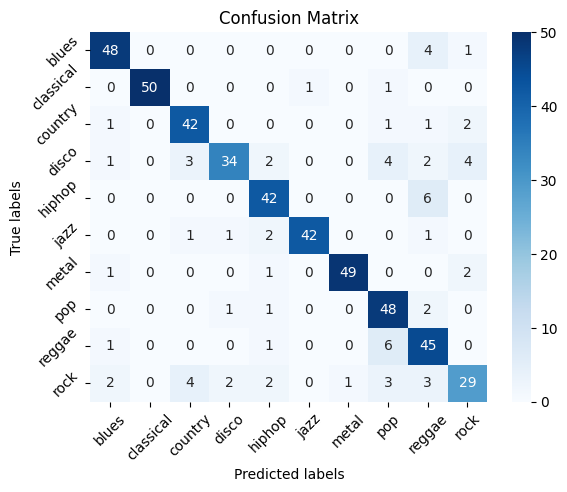

In [ ]:
# Import necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions for the test set
y_pred = model.predict(test_generator)

# Convert the predictions from one-hot encoding to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels for the test set
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Define the class labels
class_labels = list(test_generator.class_indices.keys())

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title to the plot
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", bbox_inches="tight", dpi=300)
# Display the plot
plt.show()

# **Classification Report (precision, Recall, F1-score)**

In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report

# Generate predictions for the test set
y_pred = model.predict(test_generator)

# Convert the predictions from one-hot encoding to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels for the test set
y_true = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=class_labels)

# Print the classification report
print(report)

17/17 [==============================] - 2s 133ms/step
              precision    recall  f1-score   support

       blues       0.86      0.98      0.91        49
   classical       1.00      0.96      0.98        50
     country       0.87      0.88      0.87        51
       disco       0.71      0.72      0.72        54
      hiphop       0.85      0.66      0.74        53
        jazz       0.92      1.00      0.96        47
       metal       0.98      0.81      0.88        52
         pop       0.76      0.94      0.84        50
      reggae       0.59      0.90      0.72        52
        rock       0.92      0.44      0.59        55

    accuracy                           0.82       513
   macro avg       0.85      0.83      0.82       513
weighted avg       0.84      0.82      0.82       513



# **ROC-AUC Curve**

16/16 [==============================] - 10s 637ms/step


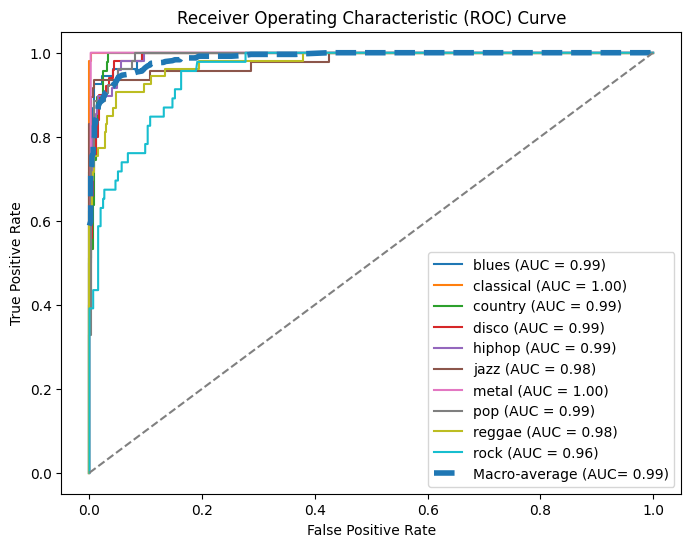

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
y_probs = model.predict(test_generator)

# Compute ROC curve and ROC area for each genre
fpr = dict()
tpr = dict()
roc_auc = dict()
for genre in test_generator.class_indices.keys():
    label = test_generator.class_indices[genre]
    y_true = (test_generator.classes == label).astype(int)
    y_score = y_probs[:, label]
    fpr[genre], tpr[genre], _ = roc_curve(y_true, y_score)
    roc_auc[genre] = auc(fpr[genre], tpr[genre])

# Compute macro-average ROC curve and ROC area
fpr_macro = np.unique(np.concatenate([fpr[genre] for genre in test_generator.class_indices.keys()]))
tpr_macro = np.zeros_like(fpr_macro)
for genre in test_generator.class_indices.keys():
    label = test_generator.class_indices[genre]
    y_true = (test_generator.classes == label).astype(int)
    y_score = y_probs[:, label]
    tpr_macro += np.interp(fpr_macro, fpr[genre], tpr[genre])
tpr_macro /= len(test_generator.class_indices)
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves for each genre
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for genre in test_generator.class_indices.keys():
    plt.plot(fpr[genre], tpr[genre], label=f'{genre} (AUC = {roc_auc[genre]:.2f})')

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC= {roc_auc_macro:.2f})', linestyle='--', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Set plot title and labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig("roc_auc_curve.png", bbox_inches="tight", dpi=300)
# Show plot
plt.show()

# **The End**







---



---



---



---



---

